In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from functools import partial
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from scipy.linalg import LinAlgWarning
import warnings
from glum import GeneralizedLinearRegressor as glm

# glmnet packages

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=LinAlgWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)

In [6]:
df = pd.read_csv("/Users/pedro.hcardoso/dev/book/marketing-book/datasets/weekly_ad_spend.csv")

In [7]:
df

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,67075.04,0.0,38185.466667,7.290385e+07,0.000000,0,8125009,22821.398744,na,19401.653846
1,2015-11-30,2.584277e+06,85840.36,0.0,0.000000,1.658110e+07,29511.715457,12400,7901549,3425.857351,na,14791.000000
2,2015-12-07,2.547387e+06,0.00,396835.2,1361.600000,4.995477e+07,36132.358958,11360,8300197,12769.126133,na,14544.000000
3,2015-12-14,2.875220e+06,250350.92,0.0,53040.000000,3.164930e+07,36804.210958,12760,8122883,8401.472031,na,2800.000000
4,2015-12-21,2.215953e+06,0.00,832008.0,0.000000,8.802269e+06,28401.744069,10840,7105985,2068.747816,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.00,96692.8,61489.466667,0.000000e+00,152840.323412,44840,7612762,0.000000,na,28157.000000
204,2019-10-21,2.182825e+06,61967.04,0.0,0.000000,5.688196e+07,103680.047821,41480,6701667,13362.457552,na,10644.000000
205,2019-10-28,2.377707e+06,8793.00,22550.4,6990.400000,0.000000e+00,138387.704138,45880,7688920,0.000000,na,9597.000000
206,2019-11-04,2.732825e+06,8981.20,0.0,9620.533333,0.000000e+00,151707.990462,53640,8815710,0.000000,na,90189.000000


In [8]:
def adstock_transform(x, retention_rate, duration=13, peak_delay=None, method='geometric'):
    
    x_adstock = np.zeros_like(x)
    
    if method == 'convolution':
        if peak_delay:
            weights = [retention_rate**((w-peak_delay)**2) for w in range(0, duration)]
        else:
            weights = [retention_rate**w for w in range(0, duration)]

        x_adstock = x.rolling(duration, min_periods=1).apply(lambda x: np.average(x[::-1], weights=weights[:len(x)]))
        
    if method == 'geometric':
        x_adstock = x + x.shift(1).fillna(0)*retention_rate
        
    return x_adstock

def hill_transform(x, slope, inflexion):
    
    inflexion = np.dot((np.min(x), np.max(x)), (1- inflexion, inflexion)) # linear interpolation/extrapolation by dot product
    x_hill = x**slope / (x**slope + inflexion**slope)
    return x_hill

In [9]:
control_features = ['competitor_sales_B', 'newsletter', 'search_clicks_P', 'facebook_I']
target_feature = 'revenue'
spend_features = ['tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']

train_test_split_fraction = (.33, .5)

model_params ={'alpha': (0.01, 1000)}

feature_params = {'tv_S': 
                       {'adstock_params': {'retention_rate': (0.3, 0.7), 'duration': (1, 15), 'peak_delay': (0, 4), 'method': 'convolution'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'ooh_S': 
                       {'adstock_params': {'retention_rate': (0.3, 0.7), 'duration': (1, 15), 'peak_delay': (0, 4), 'method': 'convolution'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'print_S': 
                       {'adstock_params': {'retention_rate': (0.3, 0.7), 'duration': (1, 15), 'peak_delay': (0, 4), 'method': 'convolution'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'search_S': 
                       {'adstock_params': {'retention_rate': (0.1, 0.3), 'method': 'geometric'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'facebook_S': 
                       {'adstock_params': {'retention_rate': (0.1, 0.3), 'method': 'geometric'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}}
                  }

In [32]:
lower_limits = [0, 0, 0, 0, 0, -np.inf, 0, 0, 0]
upper_limits = [np.inf, np.inf, np.inf, np.inf, np.inf, 0, np.inf, np.inf, np.inf]

model = glm(l1_ratio=0, alpha_search=True, family='gaussian', lower_bounds=lower_limits, 
            upper_bounds=upper_limits, max_iter=1000, scale_predictors=True)

model.fit(df[spend_features + control_features].values, df[target_feature].values)
y_hat = model.predict(df[spend_features + control_features].values)

mean_absolute_percentage_error(df[target_feature], y_hat)

0.29305069492210006

In [41]:
def optuna_trial(trial, df, control_features, target_feature, spend_features, train_test_split_fraction, feature_params, model_params):
    
    #ridge_alpha = trial.suggest_float('rigde_alpha', model_params['alpha'][0], model_params['alpha'][1])
    split_fraction = trial.suggest_float('train_test_split_fraction', train_test_split_fraction[0], train_test_split_fraction[1])
    spend_features_hill = []
    
    for feature in spend_features:
        retention_rate = trial.suggest_float(f'{feature}_retention_rate',
                                             feature_params[feature]['adstock_params']['retention_rate'][0],
                                             feature_params[feature]['adstock_params']['retention_rate'][1])
        
        if 'duration' in feature_params[feature]['adstock_params'].keys():
            duration = trial.suggest_int(f'{feature}_duration',
                                           feature_params[feature]['adstock_params']['duration'][0],
                                           feature_params[feature]['adstock_params']['duration'][1])
        else:
            duration=None
        
        if 'peak_delay' in feature_params[feature]['adstock_params'].keys():
            peak_delay = trial.suggest_int(f'{feature}_peak_delay',
                                           feature_params[feature]['adstock_params']['peak_delay'][0],
                                           feature_params[feature]['adstock_params']['peak_delay'][1])
        else:
            peak_delay = None
            
        method = feature_params[feature]['adstock_params']['method']
        
        slope = trial.suggest_float(f'{feature}_slope',
                                    feature_params[feature]['hill_params']['slope'][0],
                                    feature_params[feature]['hill_params']['slope'][1])
        
        inflexion = trial.suggest_float(f'{feature}_inflexion',
                                        feature_params[feature]['hill_params']['inflexion'][0],
                                        feature_params[feature]['hill_params']['inflexion'][1])
        
        df[f'{feature}_adstocked'] = adstock_transform(df[feature], retention_rate, duration, peak_delay, method)
        df[f'{feature}_hill'] = hill_transform(df[f'{feature}_adstocked'], slope, inflexion)
        spend_features_hill.append(f'{feature}_hill')
        
    
    lower_limits = [0, 0, 0, 0, 0, -np.inf, 0, 0, 0]
    upper_limits = [np.inf, np.inf, np.inf, np.inf, np.inf, 0, np.inf, np.inf, np.inf]
    features = spend_features_hill + control_features
    
    split_point = int(df.shape[0]*split_fraction)
    train, test = df.iloc[:split_point], df.iloc[split_point:]
    
    model = glm(l1_ratio=0, alpha_search=True, family='gaussian', lower_bounds=lower_limits, 
                upper_bounds=upper_limits, max_iter=1000, scale_predictors=True)

    model.fit(train[features], train[target_feature])
    y_hat = model.predict(test[features])
    score = mean_absolute_percentage_error(test[target_feature], y_hat)
    
    return score

objective = partial(optuna_trial,
                    df = df,
                    control_features = control_features,
                    target_feature = target_feature,
                    spend_features = spend_features,
                    train_test_split_fraction = train_test_split_fraction,
                    feature_params = feature_params,
                    model_params = model_params)

In [42]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000, show_progress_bar=True)

Best trial: 1501. Best value: 0.197198: 100%|███████████████████████████████████████| 2000/2000 [17:54<00:00,  1.86it/s]


In [43]:
study.best_params

{'train_test_split_fraction': 0.4431413342517615,
 'tv_S_retention_rate': 0.6995628865372254,
 'tv_S_duration': 12,
 'tv_S_peak_delay': 0,
 'tv_S_slope': 1.6627680487194694,
 'tv_S_inflexion': 0.1653842797910749,
 'ooh_S_retention_rate': 0.6629467959196339,
 'ooh_S_duration': 9,
 'ooh_S_peak_delay': 0,
 'ooh_S_slope': 0.746882007115435,
 'ooh_S_inflexion': 0.8786273214020425,
 'print_S_retention_rate': 0.6863876071033824,
 'print_S_duration': 13,
 'print_S_peak_delay': 4,
 'print_S_slope': 0.9965785014105573,
 'print_S_inflexion': 0.6085659077398262,
 'search_S_retention_rate': 0.10396974389195965,
 'search_S_slope': 1.1575658242551174,
 'search_S_inflexion': 0.40778685345242804,
 'facebook_S_retention_rate': 0.1743852330752176,
 'facebook_S_slope': 0.514981248127642,
 'facebook_S_inflexion': 0.8282788841100059}

In [44]:
study.best_value

0.19719844977180315

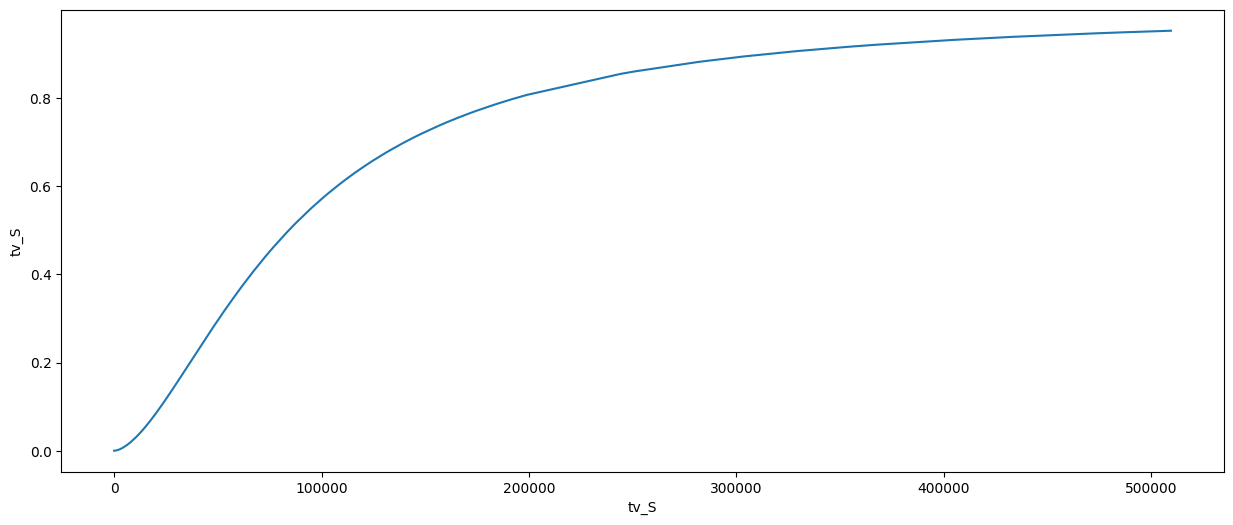

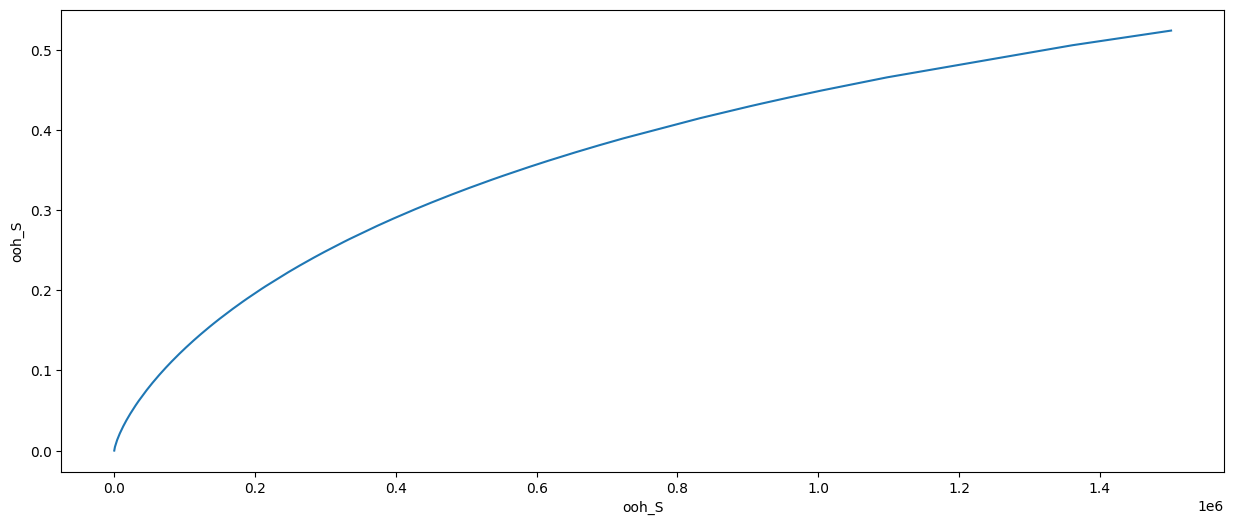

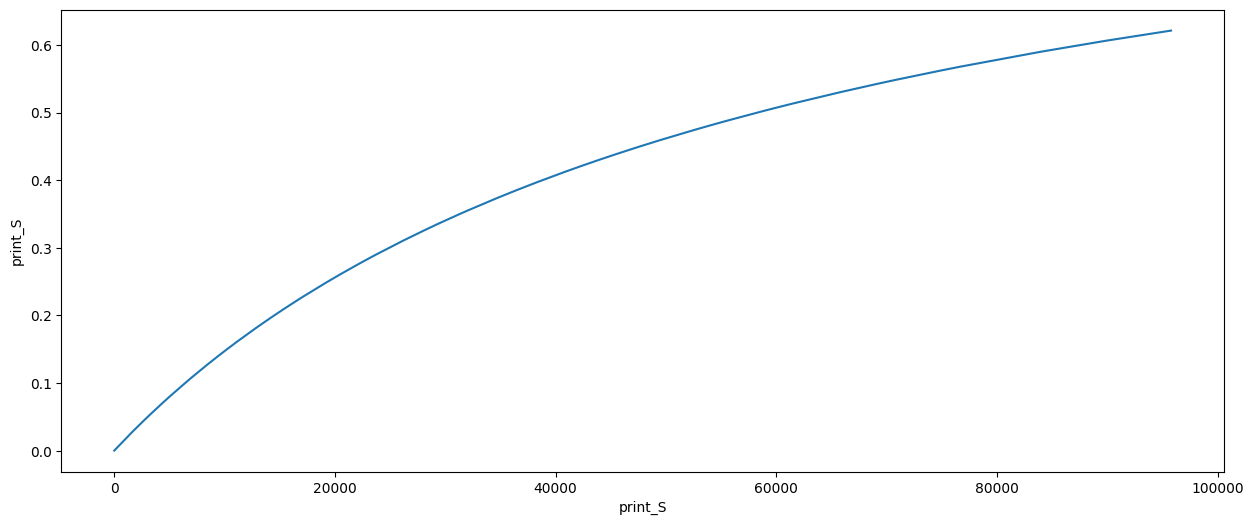

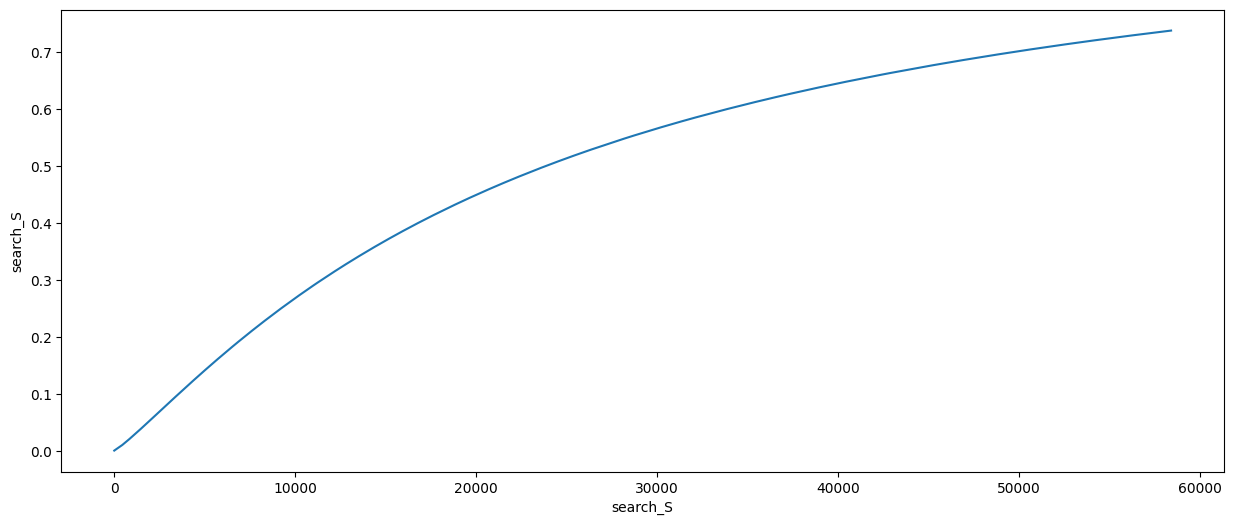

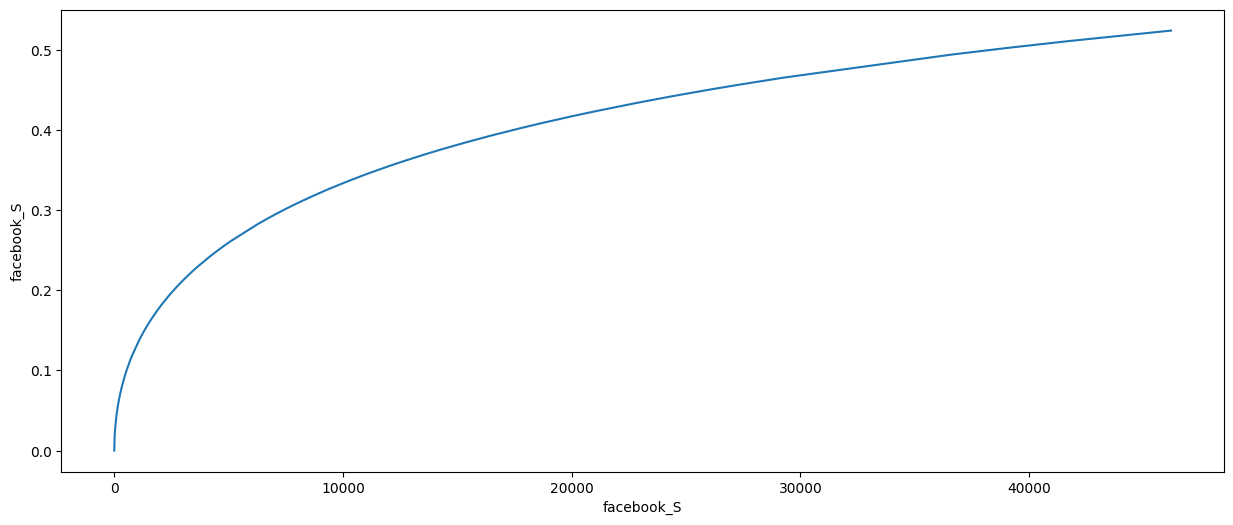

In [45]:
for feature in spend_features:
    x = df[feature]
    x_adstock = adstock_transform(x, study.best_params[f'{feature}_retention_rate'])
    x_hill = hill_transform(x_adstock, study.best_params[f'{feature}_slope'], study.best_params[f'{feature}_inflexion'])
    plt.subplots(figsize=(15,6))
    sns.lineplot(x=x_adstock, y=x_hill)
    plt.show()

In [47]:
spend_features_hill = []

for feature in spend_features:
    x = df[feature]
    x_adstock = adstock_transform(x, study.best_params[f'{feature}_retention_rate'])
    x_hill = hill_transform(x_adstock, study.best_params[f'{feature}_slope'], study.best_params[f'{feature}_inflexion'])
    df[f'{feature}_hill'] = x_hill
    spend_features_hill.append(f'{feature}_hill')

In [48]:
# rigde_alpha = study.best_params['rigde_alpha']
features = spend_features_hill + control_features

model = glm(l1_ratio=0, alpha_search=True, family='gaussian', lower_bounds=lower_limits, 
            upper_bounds=upper_limits, max_iter=1000, scale_predictors=True)

model.fit(df[features], df[target_feature])
#model = ElasticNet(alpha=0, lower_limits=lower_limits, upper_limits=upper_limits, n_splits=0, lambda_path=[0, rigde_alpha])
#model.fit(df[features], df[target_feature])

GeneralizedLinearRegressor(alpha_search=True, family='gaussian',
                           lower_bounds=[0, 0, 0, 0, 0, -inf, 0, 0, 0],
                           max_iter=1000, scale_predictors=True,
                           upper_bounds=[inf, inf, inf, inf, inf, 0, inf, inf,
                                         inf])

In [49]:
y_hat = model.predict(df[features])
score = mean_absolute_percentage_error(df[target_feature], y_hat)
score

0.2320457879802524

In [52]:
pd.DataFrame.from_dict({'feature':pd.Series(features), 'coef': pd.Series(model.coef_)})

,feature,coef
0,tv_S_hill,871899.41364
1,ooh_S_hill,956559.57277
2,print_S_hill,467197.97432
3,search_S_hill,0.00000
4,facebook_S_hill,1346347.73092
5,competitor_sales_B,0.00000
6,newsletter,6.86293
7,search_clicks_P,4.40839
8,facebook_I,0.00000


In [53]:
df['y_hat'] = y_hat

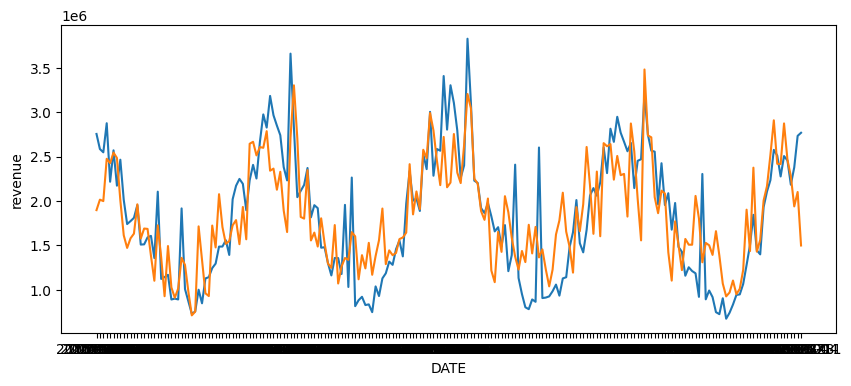

In [56]:
plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x='DATE', y='revenue')
sns.lineplot(data=df, x='DATE', y='y_hat')
plt.show()